<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/20news/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
This notebook shows how to use classify articles with Random Forest in Hivemall using 20news dataset.

# SetUp

Executing a following cell, you are asked to input some information.

In [20]:
from getpass import getpass
td_api_key = getpass('Enter TD API KEY here ')
database   = input('Enter YOUR DATABASE to create tables here ')
assert database, "Error: Input YOUR DATABASE"
endpoint   = input('Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") \nref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints ')
endpoint = endpoint if endpoint else 'https://api.treasuredata.com/'
endpoint = 'https://' + endpoint if not endpoint.startswith('https://') else endpoint
use_spark  = input('If enable to use spark, enter "true" (default: false) ').lower()
use_spark  = use_spark == 'true'
table = 'news20'

Enter TD API KEY here ··········
Enter YOUR DATABASE to create tables here hivemall
Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") 
ref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints 
If enable to use spark, enter "true" (default: false) true


In [0]:
%%capture
!pip install td-client
!pip install pandas-td
!pip install -q git+https://github.com/takuti/pytd@master#egg=treasure-data[spark]

import numpy as np
import pandas as pd
import pandas_td as td
import matplotlib.pyplot as plt
import seaborn as sns
import pytd
import tdclient
pd.options.display.max_columns = 30

%matplotlib inline
con = td.connect(apikey=td_api_key, endpoint=endpoint)
c = tdclient.Client(apikey=td_api_key, endpoint=endpoint)
presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

# Data Preparation

## Fetch data
It's done by using scikit-learn.

In [0]:
import time
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')
targets = [data['target_names'][idx] for idx in data['target']]
df = pd.DataFrame({'target':targets, 'text':data['data']})
df['article_id'] = df.index

## Create a table on Treasure Data

In [0]:
if use_spark:
  client = pytd.Client(database=database, apikey=td_api_key)
  client.load_table_from_dataframe(df.reset_index(), '{}.{}'.format(database, table), if_exists='overwrite')
else:
  if table in [table.name for table in c.tables(database)]:
    c.delete_table(database, table)
  td.to_td(df, '{}.{}'.format(database, table), con)

# EDA (Explore data analysis)
Before executing machine learning tasks, you should understand your data correctly.  
Descriptive statistics and visualization are important for this.

## Data Sample

In [24]:
td.read_td_query('''
select
  *
from
  news20
limit 2''', engine=presto)

,index,target,text,article_id,time
0,0,rec.sport.hockey,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,0,1550827797
1,1,comp.sys.ibm.pc.hardware,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,1,1550827797


## Data size

In [25]:
td.read_td_query('''
select 
  count(*) as n_article
  ,count(distinct target) as n_class 
from 
  news20
''', engine=presto)

,n_article,n_class
0,18846,20


## Target

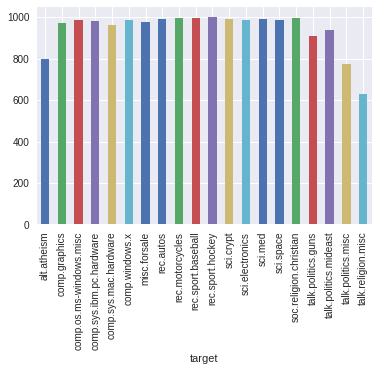

In [26]:
td.read_td_query('''
  select
    target
    ,count(*) as n
  from
    news20
  group by
    1
  order by
    target
'''.format(table=table), engine=presto, index_col='target')['n'].plot.bar()

## The number of word for each article

### Preprocess
`tokenize` function splits a text into words.  
https://hivemall.incubator.apache.org/userguide/misc/tokenizer.html

In [27]:
td.read_td_query('''
select
  target
  ,text
  ,tokenize(text, true) as tokenized
  ,size(tokenize(text, true)) as n_word
from
  news20
limit 5
''', engine=hive)

,target,text,tokenized,n_word
0,rec.sport.hockey,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,"[from, mamatha, devineni, ratnam, mr47+@andrew...",162
1,comp.sys.ibm.pc.hardware,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,"[from, mblawson@midway, ecn, uoknor, edu, matt...",144
2,talk.politics.mideast,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,"[from, hilmi-er@dsv, su, se, hilmi, eren, subj...",616
3,comp.sys.ibm.pc.hardware,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,"[from, guyd@austin, ibm, com, guy, dawson, sub...",527
4,comp.sys.mac.hardware,From: Alexander Samuel McDiarmid <am2o+@andrew...,"[from, alexander, samuel, mcdiarmid, am2o+@and...",157


### View data

In [28]:
td.read_td_query('''
  select
    size(tokenize(text, true)) as n_word
  from
    news20
''', engine=hive).describe()

,n_word
count,18846.000000
mean,310.510665
std,690.912549
min,15.000000
25%,117.000000
50%,187.000000
75%,307.000000
max,31621.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37180ac438>]],
      dtype=object)

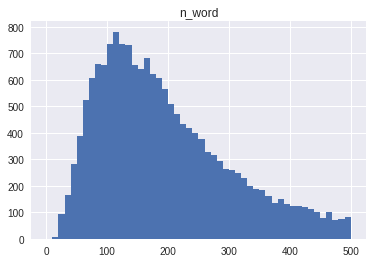

In [29]:
td.read_td_query('''
  select
    size(tokenize(text, true)) as n_word
  from
    news20
''', engine=hive).hist(range=(0,500), bins=50)

In [0]:
data = td.read_td_query('''
  select
    target
    ,avg(size(tokenize(text, true))) as average
    ,variance(size(tokenize(text, true))) as variance
  from
    news20
  group by
    1
  order by
    1
''', engine=hive, index_col='target')

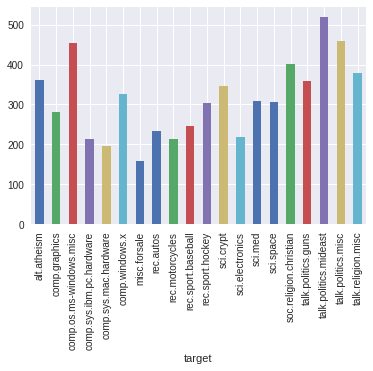

In [31]:
data['average'].plot.bar()

# Run machine learning task

## Tokenize text

In [32]:
if 'news20_text_parsed' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_text_parsed')
c.create_log_table(database, 'news20_text_parsed')

True

This query will take a long time (about 20 min)

In [33]:
td.read_td_query('''
insert into table news20_text_parsed
select
  article_id
  ,target
  ,text
  ,word
  ,count(*) as n
from
  news20  
lateral view
  explode(tokenize(text, true)) t as word
group by
  1,2,3,4
''', engine=hive)

,article_id,target,text,word,n


Check the created table.

In [34]:
td.read_td_query('''
select
  *
from
  news20_text_parsed
order by
  n desc
limit 5
''', engine=presto)

,article_id,target,text,word,n,time
0,12042,comp.os.ms-windows.misc,Subject: roman.bmp 12/14 \nFrom: pwiseman@salm...,ax,11142,1550828015
1,7829,comp.os.ms-windows.misc,Subject: roman.bmp 13/14\nFrom: pwiseman@salmo...,ax,9632,1550828015
2,5017,comp.os.ms-windows.misc,Subject: roman.bmp 11/14 \nFrom: pwiseman@salm...,ax,9152,1550828015
3,8452,comp.os.ms-windows.misc,Subject: roman.bmp 07/14\nFrom: pwiseman@salmo...,ax,7636,1550828015
4,9443,comp.os.ms-windows.misc,Subject: roman.bmp 08/14\nFrom: pwiseman@salmo...,ax,5971,1550828015


## Add weight with td-idf
You can use `n` as weight of each word, but there is a better way.  
TD-IDF is a value representing the importance of word in each texts.  
[Wikipedia of tf-idf in English](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
[Wikipedia of tf-idf in Japanese](https://ja.wikipedia.org/wiki/Tf-idf)


In [35]:
if 'news20_tfidf_added' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_tfidf_added')
c.create_log_table(database, 'news20_tfidf_added')

True

This query will take a long time (about 20 min)

In [36]:
td.read_td_query('''
insert into news20_tfidf_added 
with tf as (
  select
    article_id
    ,word
    ,cast(count(*) as double) / sum(count(*)) over(partition by article_id) as tf
  from
    news20_text_parsed
  group by
    1,2
)

,df as (
  select
    word
    ,cast(count(distinct article_id) as double) / (select count(distinct article_id) from news20_text_parsed) as df
  from
    news20_text_parsed
  group by
    1
)

select
  t.article_id
  ,t.target
  ,t.text
  ,replace(t.word, ':|#', '') as word -- remove ":" and "#"
  ,t.n
  ,tf.tf * ln(power(df.df, -1)) as tfidf
from
  news20_text_parsed t
  inner join
  tf
  on
    t.article_id = tf.article_id
    and
    t.word = tf.word
  inner join
  df
  on
    t.word = df.word
''', engine=presto)

,rows
0,3094185


Check the created table.

In [37]:
td.read_td_query('''
select
  *
from
  news20_tfidf_added
order by
  tfidf desc
limit 5
''', engine=presto)

,article_id,target,text,word,n,tfidf,time
0,16653,alt.atheism,From: Edwin Gans\nSubject: Atheism\nNntp-Posti...,gans,1,0.656270,1550830126
1,6426,comp.windows.x,From: skji@eve.kaist.ac.KR (Ji SoonKi)\nSubjec...,soonki,1,0.615253,1550830126
2,6426,comp.windows.x,From: skji@eve.kaist.ac.KR (Ji SoonKi)\nSubjec...,skji@eve,2,0.615253,1550830126
3,15892,comp.sys.mac.hardware,From: kwgst+@pitt.edu (Mr. Someone)\nSubject: ...,pre-ee,1,0.579062,1550830126
4,17438,talk.politics.misc,Organization: Arizona State University\nFrom: ...,cxnbk@asuacad,1,0.579062,1550830126


## Aggregate data and split into training data and test data
The data is splitted into training data and test data.  
Articles whose article_id's ones place in 7 or 8 or 9 are assigned to test data,  
others are assigned to training data.  
Machine learning model is created by training data, and it's evaluated by test data.

Also, data is aggregated so as to 1 record / 1 article.

In [38]:
if 'news20_aggregate' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_aggregate')
c.create_log_table(database, 'news20_aggregate')

True

In [39]:
td.read_td_query('''
insert overwrite table news20_aggregate
select
  article_id
  ,target
  ,case when article_id % 10 in (7,8,9) then 'test' else 'train' end as class
  ,collect_set(feature(word, tfidf)) as word_with_weight
  ,sum(n) as n_word
from
  news20_tfidf_added
group by
  1,2
''', engine=hive)

,article_id,target,class,word_with_weight,n_word


Check the created table.

In [40]:
td.read_td_query('''
select
  *
from
  news20_aggregate
limit 5
''', engine=presto)

,article_id,target,class,word_with_weight,n_word,time
0,2,talk.politics.mideast,train,"[one:0.003444610544738086, tortured:0.02035440...",616,1550830433
1,20,rec.autos,train,"[never:0.008982596476172285, begin:0.017396486...",406,1550830433
2,22,comp.graphics,train,"[posting:0.024547637995487346, imagine:0.03011...",194,1550830433
3,25,sci.space,train,"[auspices:0.14117480776521574, under:0.0441177...",68,1550830433
4,28,misc.forsale,test,"[card:0.01778179257999286, sale:0.018412630857...",239,1550830433


## Convert data into Hivemall input format

In [41]:
if 'news20_train_data' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_train_data')
c.create_log_table(database, 'news20_train_data')

True

In [42]:
td.read_td_query('''
insert overwrite table news20_train_data
select
  article_id
  ,target
  ,(dense_rank() over(order by target)) - 1 as target_id
  ,class
  ,word_with_weight
  ,n_word
  ,array_concat(feature_hashing(word_with_weight, '-features 1000'), array(feature(1001, n_word))) as sparse_features 
  ,to_dense_features(array_concat(feature_hashing(word_with_weight, '-features 1000'), array(feature(1001, n_word))), 1001) as dense_features 
from
  news20_aggregate
''', engine=hive)

,article_id,target,target_id,class,word_with_weight,n_word,sparse_features,dense_features


Check the created table.

In [43]:
td.read_td_query('''
select
  *
from
  news20_train_data
limit 5
''', engine=presto)

,article_id,target,target_id,class,word_with_weight,n_word,sparse_features,dense_features,time
0,7172,alt.atheism,0,train,"[belong:0.0964078879139117, technology:0.05396...",62,"[489:0.0964078879139117, 577:0.053966938307285...","[None, None, None, 0.03259481489658356, None, ...",1550830489
1,6358,alt.atheism,0,test,"[53:0.010039001717028867, same:0.0044857008088...",898,"[199:0.010039001717028867, 912:0.0044857008088...","[None, 0.010309834964573383, None, 0.004955134...",1550830489
2,17245,alt.atheism,0,train,"[old:0.011693441373030368, t:0.002852660355647...",438,"[966:0.011693441373030368, 393:0.0028526603556...","[None, None, None, 0.02151159942150116, 0.0118...",1550830489
3,5704,alt.atheism,0,train,"[at:0.005459553569856588, more:0.0083509794154...",244,"[431:0.005459553569856588, 976:0.0083509794154...","[None, 0.04473377391695976, None, 0.0141156129...",1550830489
4,10559,alt.atheism,0,test,"[livesey:0.04592478216941326, against:0.023111...",177,"[866:0.04592478216941326, 645:0.02311129191529...","[None, None, None, 0.014842281118035316, None,...",1550830489


## Build a model with Random Forest Classifier
[wikipdia of RandomForest in English](https://en.wikipedia.org/wiki/Random_forest)  
[wikipdia of RandomForest in Japanese](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%83%95%E3%82%A9%E3%83%AC%E3%82%B9%E3%83%88)

In [44]:
if 'news20_randomforest_model' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_randomforest_model')
c.create_log_table(database, 'news20_randomforest_model')

True

In [45]:
td.read_td_query('''
insert overwrite table news20_randomforest_model
select
  train_randomforest_classifier(dense_features, target_id, '-trees 50')
  -- train_randomforest_classifier(dense_features, target_id, '-trees 50 -splits 10 -leafs 1 -depth 1000')
from
  news20_train_data
where
  class = 'train'
''', engine=hive)

,model_id,model_weight,model,var_importance,oob_errors,oob_tests


Check the created table.

In [46]:
td.read_td_query('''
select
  *
from
  news20_randomforest_model
limit 5
''', engine=presto)

,model_id,model_weight,model,var_importance,oob_errors,oob_tests,time
0,b0aeed97-8200-4c10-af8b-07107f8631f6,0.159585,"I?brQF<ZO5gr>%e4,B&F&(3~dRVRuc{P0cO5TDCYiahjx-...","[0.0, 0.9679546328335256, 2.2039429168316436, ...",0,0,1550830555
1,1cbf4a2f-65a9-4a6d-b8b3-19a2cd8db019,0.175987,I?brQF_Z7i*s>%sE4Ws4av1wmLNZy~9kB)QcN0[WFxlB;X...,"[0.0, 1.051716531487942, 1.0344598653521917, 4...",0,0,1550830555
2,c5458fb8-69d3-4cb9-9118-0afb2d074e67,0.169745,I?brQFBV8>`}VD-HMMuc$ElH)H%ttB]G_h*gSt%cxrXIP7...,"[0.0, 0.6291322314049588, 2.4426001449540626, ...",0,0,1550830555
3,a5d5ae50-c941-42a4-9f2e-fd13a6f75b38,0.171901,I?brQFcU|7$rWDd{b7B*$/q~}95Ft4V3}tB;@te!{LC6~q...,"[0.0, 1.0991076334379908, 2.784869434901934, 2...",0,0,1550830555
4,4bcf9c64-29fb-4447-bbdc-1ddbae260025,0.170783,"I?brQFBV7i,stG&tFw}96S@D-w/h^{{G)H_txds4WE~.c<...","[0.0, 0.9351118901556178, 1.3856907086589905, ...",0,0,1550830555


## Predict

In [47]:
if 'news20_randomforest_predicted' in [table.name for table in c.tables(database)]:
  c.delete_table(database, 'news20_randomforest_predicted')
c.create_log_table(database, 'news20_randomforest_predicted')

True

In [48]:
td.read_td_query('''
insert overwrite table news20_randomforest_predicted
SELECT
  article_id,
  class,
  target_id,
  rf_ensemble(predicted.value, predicted.posteriori, model_weight).label as predicted
FROM (
  SELECT
    t.article_id,
    class,
    target_id,
    p.model_weight,
    tree_predict(p.model_id, p.model, t.dense_features, "-classification") as predicted
  FROM (
    SELECT 
      model_id, model_weight, model
    FROM news20_randomforest_model
    DISTRIBUTE BY rand(1)
  ) p
  LEFT OUTER JOIN news20_train_data t
) t1
group by
  1,2,3
''', engine=hive)

,article_id,class,target_id,predicted


Check the created table.

In [49]:
td.read_td_query('''
select
  *
from
  news20_randomforest_predicted
limit 5
''', engine=presto)

,article_id,class,target_id,predicted,time
0,0,train,10,10,1550830929
1,1,train,3,3,1550830929
2,2,train,17,17,1550830929
3,3,train,3,3,1550830929
4,4,train,4,4,1550830929


## Evaluate

### Train

Accuracy : 99.94% (= 13,186.0 / 13,194.0)


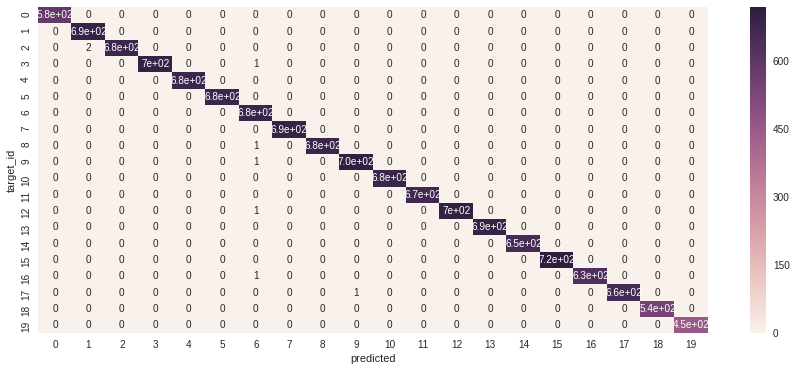

In [50]:
result = td.read_td_query('''
  select
    class
    ,target_id
    ,predicted
    ,count(*) as n
  from
    news20_randomforest_predicted
  where
    class = 'train'
  group by
    1,2,3
''', engine=presto).pivot(index='target_id', columns='predicted', values='n').fillna(0)

# Calculate the accuracy
n_correct = np.trace(result)
n_total = result.sum().sum()
print('Accuracy : {:.2%} (= {:,} / {:,})'.format(n_correct / n_total, n_correct, n_total))

# Picture
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(result, annot=True, ax=ax)
plt.show()

### Test

Accuracy : 51.26% (= 2,897.0 / 5,652.0)


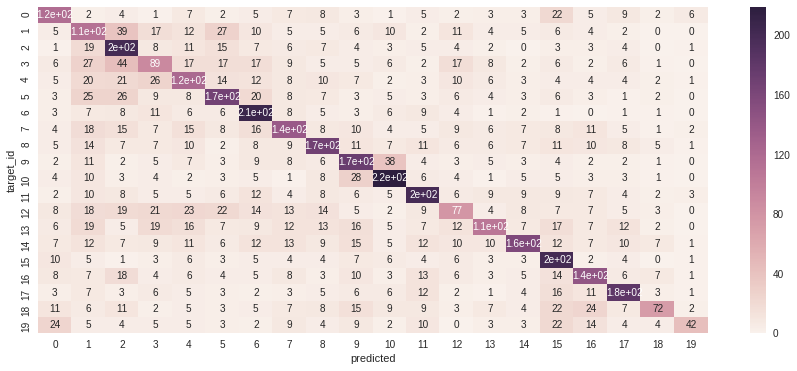

In [51]:
result = td.read_td_query('''
  select
    class
    ,target_id
    ,predicted
    ,count(*) as n
  from
    news20_randomforest_predicted
  where
    class = 'test'
  group by
    1,2,3
''', engine=presto).pivot(index='target_id', columns='predicted', values='n').fillna(0)

# Calculate the accuracy
n_correct = np.trace(result)
n_total = result.sum().sum()
print('Accuracy : {:.2%} (= {:,} / {:,})'.format(n_correct / n_total, n_correct, n_total))

# Picture
fig, ax = plt.subplots(figsize=(15,6))
sns.heatmap(result, annot=True, ax=ax)
plt.show()

## Check the variable importance
The bigger the value is, the better it is.

In [52]:
td.read_td_query('''
select
  n as index
  ,subarray(importances, n-1, n)[0] as importance
from (
  select
    array_sum(var_importance) as importances
  from 
    news20_randomforest_model
  ) t
lateral view
  generate_series(1,1001) t as n
limit 5
''', engine=hive)

,index,importance
0,1,0.000000
1,2,42.339769
2,3,75.248267
3,4,189.267560
4,5,33.590422
